In [33]:
import numpy as np
import pandas as pd
import matplotlib as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

plt.style.use('seaborn-v0_8-notebook')
df = pd.read_csv('../input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv')

/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


**Date** is the trading date

**High** and **Low** refer to the maximum and minimum prices in a given time period.

**Open** and **Close** are the prices at which a stock began and ended trading in the same period.

**Volume** is the total amount of trading activity

**Adj Close** is the adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.


In [35]:
type(df.iloc[0][0])

str

Instead of strings let's store the dates as pandas timestamps.

In [36]:
df['Date'] = df['Date'].astype('datetime64[ns]')
df.describe()

,Date,High,Low,Open,Close,Volume,Adj Close
count,1825,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2018-05-23 00:00:00,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
min,2015-11-23 00:00:00,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2017-02-21 00:00:00,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2018-05-23 00:00:00,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2019-08-22 00:00:00,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,2020-11-20 00:00:00,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912
std,NaN,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177


In [37]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


Let's check if we have any missing data. There are no null values, which is great, but let's also check if there are no missing or duplicate dates.

In [38]:
import datetime
len(df['Date'].unique())

1825

No duplicates. Any missing days? We know the min and max timestamps: 2015-11-23 and 2020-11-20. As there are 1825 rows, the difference between these two dates should be 1824 days.

In [39]:
start_date = datetime.date(2015,11,23) + datetime.timedelta(days=1824)
start_date

datetime.date(2020, 11, 20)

Awesome! Let's get some insight!

<Axes: xlabel='Date', ylabel='Open'>

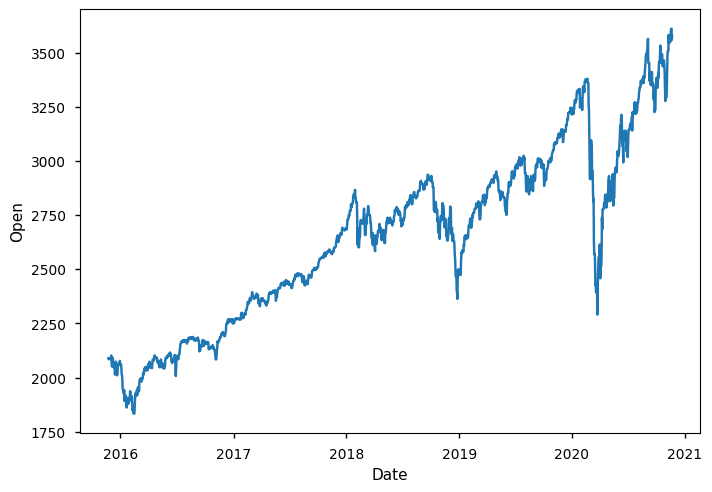

In [40]:
import seaborn as sns

sns.lineplot(data=df, x='Date', y ='Open')

<Axes: xlabel='Date', ylabel='Volume'>

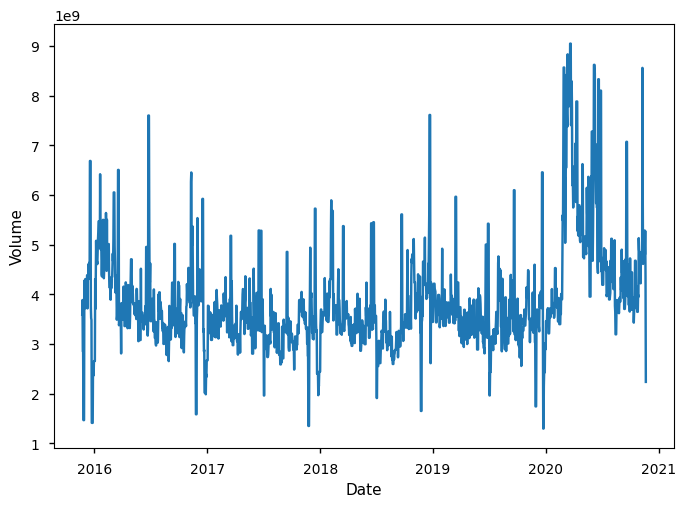

In [41]:
sns.lineplot(data=df, x='Date', y ='Volume')

In [42]:
df.corr()

,Date,High,Low,Open,Close,Volume,Adj Close
Date,1.000000,0.943581,0.931224,0.938134,0.937722,0.242046,0.937722
High,0.943581,1.000000,0.998154,0.999328,0.998958,0.084212,0.998958
Low,0.931224,0.998154,1.000000,0.998794,0.999020,0.044557,0.999020
Open,0.938134,0.999328,0.998794,1.000000,0.998344,0.069729,0.998344
Close,0.937722,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000
Volume,0.242046,0.084212,0.044557,0.069729,0.063401,1.000000,0.063401
Adj Close,0.937722,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000


These are very high correlation coefficients. But of course the price usually does not change much in a day, so High, Low, Open, Close indeed should be highly correlated.

There is also a clear increasing trend, this explains why Date is highly correlated with the price.

Volume is not corralated with other columns.

In [43]:
# first we go with the closing prices
values = df.values[:1820, 2:3]

train_size = 1200
test_size = 620

In [44]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
values_scaled = sc.fit_transform(values)

In [45]:
timesteps = 10
batch_size = 1

upper_train = train_size + 2 * timesteps
train_set_scaled = values_scaled[:upper_train]

train_set_scaled.shape

(1220, 1)

In [46]:
Y_train = []
X_train = []

for i in range(timesteps, train_size + timesteps):
    X_train.append(train_set_scaled[i-timesteps:i,0])
    Y_train.append(train_set_scaled[i,0])
    
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
Y_train = np.reshape(Y_train, (Y_train.shape[0]))

print(X_train.shape)
print(Y_train.shape)


test_set_scaled = values_scaled[train_size - timesteps:]

X_test = []
Y_test = []

for i in range(timesteps, test_size - timesteps):
    X_test.append(test_set_scaled[i-timesteps:i,0])
    Y_test.append(test_set_scaled[i,0])

X_test = np.asarray(X_test).astype('float32')
Y_test = np.asarray(Y_test).astype('float32')

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
Y_test = np.reshape(Y_test, (Y_test.shape[0]))

print(X_test.shape)
print(Y_test.shape)

(1200, 10)
(1200,)
(600, 10)
(600,)


In [47]:
X_test

array([[0.563793  , 0.5606331 , 0.55242425, ..., 0.5481481 , 0.55691224,
        0.54873776],
       [0.5606331 , 0.55242425, 0.5566489 , ..., 0.55691224, 0.54873776,
        0.53179353],
       [0.55242425, 0.5566489 , 0.5594367 , ..., 0.54873776, 0.53179353,
        0.522165  ],
       ...,
       [0.9562368 , 0.9335336 , 0.9561795 , ..., 0.9290515 , 0.9189078 ,
        0.9332818 ],
       [0.9335336 , 0.9561795 , 0.9561795 , ..., 0.9189078 , 0.9332818 ,
        0.9332818 ],
       [0.9561795 , 0.9561795 , 0.9561795 , ..., 0.9332818 , 0.9332818 ,
        0.9332818 ]], dtype=float32)

I want to compare three models. First I define a naive model for benchmarking. It simply predicts the following day's price to be the same. Then I will use a stateful and a stateless lstm model.

In [48]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, LSTM, Dropout

model_stateless=Sequential()
model_stateless.add(LSTM(10, stateful=False, return_sequences=True, batch_size=batch_size, input_shape=(X_train.shape[1],1)))
model_stateless.add(Dense(25))
model_stateless.add(Dense(1))
model_stateless.compile(loss='mean_squared_error', optimizer='adam')
model_stateless.summary()

model_stateless.fit(X_train, Y_train, epochs=5, batch_size=batch_size)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (1, 10, 10)               480       
                                                                 
 dense_7 (Dense)             (1, 10, 25)               275       
                                                                 
 dense_8 (Dense)             (1, 10, 1)                26        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1200/1200 [==============================] - 10s 6ms/step - loss: 0.0042
Epoch 2/10
1200/1200 [==============================] - 7s 6ms/step - loss: 8.9258e-04
Epoch 3/10
1200/1200 [==============================] - 7s 6ms/step - loss: 7.3375e-04
Epoch 4/10
1200/1200 [==============================] - 7s 6ms

In [49]:
input_1 = Input(batch_shape=(batch_size, timesteps, 1))
lstm_1 = LSTM(1, stateful=True, return_sequences=True)(input_1)
lstm_2 = LSTM(10, stateful=True, return_sequences=True)(lstm_1)
output_1 = Dense(units = 1)(lstm_2)

model_stateful = Model(inputs=input_1, outputs=output_1)

model_stateful.compile(loss='mean_squared_error', optimizer='adam')
model_stateful.summary()
model_stateful.fit(X_train, Y_train, epochs=7, batch_size=batch_size)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(1, 10, 1)]              0         
                                                                 
 lstm_12 (LSTM)              (1, 10, 1)                12        
                                                                 
 lstm_13 (LSTM)              (1, 10, 10)               480       
                                                                 
 dense_9 (Dense)             (1, 10, 1)                11        
                                                                 
Total params: 503
Trainable params: 503
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1200/1200 [==============================] - 14s 8ms/step - loss: 0.0218
Epoch 2/20
1200/1200 [==============================] - 10s 8ms/step - loss: 0.0058
Epoch 3/20
1200/1200 [===

In [50]:
#model_naive
naive_prediction_train = np.roll(Y_train, 1)
naive_prediction_test = np.roll(Y_test, 1)

predictions_stateless_train = model_stateless.predict(X_train, batch_size=batch_size)
predictions_stateless_test = model_stateless.predict(X_test, batch_size=batch_size)

predictions_stateful_train = model_stateful.predict(X_train, batch_size=batch_size)
predictions_stateful_test = model_stateful.predict(X_test, batch_size=batch_size)

600/600 [==============================] - 2s 4ms/step


In [51]:
print(naive_prediction_test[:10])
predictions_stateless_train = np.reshape(predictions_stateless_train[:,0,0], (predictions_stateless_train.shape[0]))
predictions_stateless_test = np.reshape(predictions_stateless_test[:,0,0], (predictions_stateless_test.shape[0]))
print(predictions_stateless_train[:10])
print(predictions_stateless_test[:10])
predictions_stateful_train = np.reshape(predictions_stateful_train[:,0,0], (predictions_stateful_train.shape[0]))
predictions_stateful_test = np.reshape(predictions_stateful_test[:,0,0], (predictions_stateful_test.shape[0]))
print(predictions_stateful_train[:10])
print(predictions_stateful_test[:10])

[0.89001095 0.53179353 0.522165   0.522165   0.522165   0.53667074
 0.5590646  0.56653506 0.5686416  0.57283765]
[0.16578662 0.15989652 0.16839488 0.16839488 0.16724187 0.16724187
 0.16724187 0.16526626 0.1666045  0.16351457]
[0.5569998  0.553919   0.54591674 0.5500349  0.55275255 0.55275255
 0.55275255 0.5417489  0.55029154 0.5423236 ]
[0.15424496 0.15483041 0.16407147 0.16381712 0.16258599 0.16263026
 0.16258645 0.1605804  0.16199367 0.15853441]
[0.564287   0.56104726 0.5540768  0.5571261  0.55915064 0.5590785
 0.55910903 0.5504605  0.5581779  0.5519211 ]


In [52]:
from sklearn.metrics import mean_squared_error

print('Naive')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, naive_prediction_train)))
print('Test rmse:', np.sqrt(mean_squared_error(Y_test, naive_prediction_test)))

print('Stateless')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, predictions_stateless_train)))
print('Test rmse:', np.sqrt(mean_squared_error(Y_test, predictions_stateless_test)))

print('Stateful')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, predictions_stateful_train)))
print('Test rmse:', np.sqrt(mean_squared_error(Y_test, predictions_stateful_test)))

Naive
Train rmse: 0.015868401
Test rmse: 0.023633545
Stateless
Train rmse: 0.032160897
Test rmse: 0.067885846
Stateful
Train rmse: 0.030770043
Test rmse: 0.087154776


<Axes: xlabel='Date'>

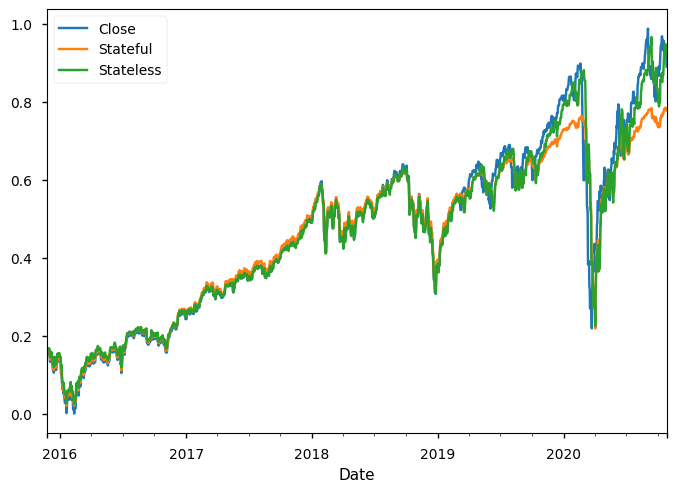

In [53]:
test_data = pd.DataFrame()
test_data['Date'] = df['Date'][:1800]
test_data['Close'] = values_scaled[:1800]
test_data['Naive'] = np.concatenate((naive_prediction_train, naive_prediction_test))
test_data['Stateless'] = np.concatenate((predictions_stateless_train, predictions_stateless_test))
test_data['Stateful'] = np.concatenate((predictions_stateful_train, predictions_stateful_test))

test_data.plot(x='Date', y=['Close','Stateful','Stateless'])